## Tensorboard

(based on a tutorial by Python Engineer in Youtube)

Tensorboard is a visualization tool to analyze our model and training pipeline.

- Tracking and visualizing metrics such as loss and accuracy
- Visualizing the model graph (ops and layers)
- Viewing histograms of weights, biases, or other tensors as they change over time
- Projecting embeddings to a lower dimensional space
- Displaying images, text, and audio data
- Profiling TensorFlow programs
- And much more


In [156]:
import torch
import html 
import cgi 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sys
import matplotlib.pyplot as plt

In [157]:
#added for tensorboard------------
from torch.utils.tensorboard import SummaryWriter
#create a writer with the directory
writer = SummaryWriter("runs/mnist")
#added for tensorboard------------

In [158]:
#device config
#if we have GPU it will work with it else with CPU, we must push our tensors to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [159]:
# hyperparameters
input_size = 784   #because the images are 28x28 and we will flat the array to 1D tensor
hidden_size = 500  #you can use other dim too.
num_classes = 10   #we have 10 classes in the dataset
num_epochs = 1      #so that it won't get long time
batch_size = 64
learning_rate = 0.01

In [160]:
# import MNIST data
#must be in the same folder, it's for training, we add a transform and convert data to tensors, it must be 
#downloaded if we have'nt done that yet
train_dataset = torchvision.datasets.MNIST(root='./data', train=True
                                          ,transform = transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False
                                          ,transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size
                                          , shuffle=True) # shuffle is good for training

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [161]:
#let's look at one batch of this data
examples = iter(train_loader)
example_data, example_targets = examples.next()
print(example_data.shape, example_targets.shape) 

torch.Size([64, 1, 28, 28]) torch.Size([64])


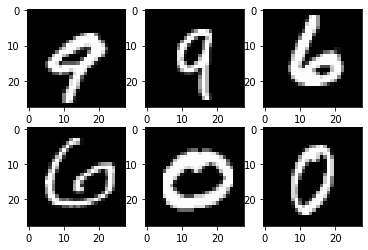

In [162]:
#plot
for i in range(6):
    plt.subplot(2, 3, i+1)   #2 raws, 3 columns, in index i+1
    plt.imshow(example_data[i][0], cmap='gray')
    #we want to show the actual data here, [i][0] to access the first channel, and the color map is set to gray


In [163]:
#added for tensorboard------------
#instead of plotting plt.show() we can add the images into tensorboard
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image('mnist_images',img_grid)

writer.close()   #all the outputs have been flashed

# if you were in the middle of a code and you were coding in visual studio for example and just wanted to see
# the data you must put a code to exit here so sys.exit()
#added for tensorboard------------

Now if we reload the tab of tensorboard, we will see:
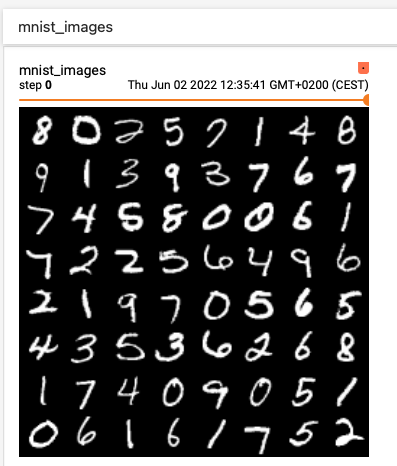

Now the remain of the code.
We want to create a graph to analyse our model.

In [164]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes): #num_classes is the output size
        super(NeuralNet, self).__init__()
        
        #fist layer
        self.l1 = nn.Linear(input_size, hidden_size)
        
        #activation function
        self.relu = nn.ReLU()
        
        #another linear layer
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        #now we use all above layers
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        
        #cross entropy will implement softmax,too, so we don't add softmax here
        
        return out
    

model = NeuralNet(input_size, hidden_size, num_classes)

#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [165]:
#tensorboard building a graph
# we need the model and a batch of data
#then we must reshape it
writer.add_graph(model, example_data.reshape(-1, 28*28))



#reloading tensorboard we can see that now we have a graph tab

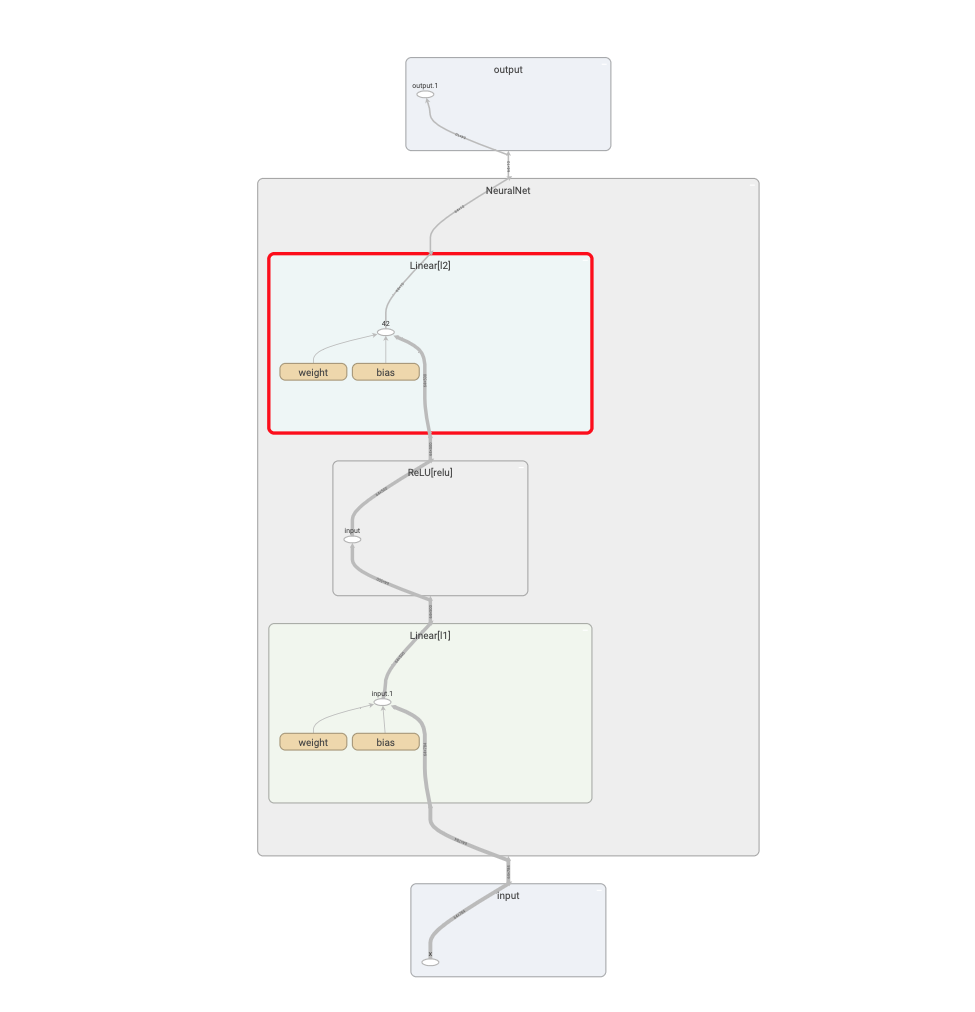

In [166]:
#let's add the training loss and accuracy to the logs
#so we need the mean of losses

running_loss = 0.0
running_correct = 0 #predictions

In [167]:
#training loop
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):    #unpacking, enumerate give us the index
        #we have to reshape our images first because this is 100 * 1 * 28 * 28
        #but now input size is 784 so our images tensors needs the size 100 * 784
        #first the number of batches then images size
        images = images.reshape(-1, 28*28).to(device) # and send it to GPU if it's there
        
        labels = labels.to(device)
        
        #forward
        outputs = model(images)
        loss = criterion(outputs, labels) #predicted output and actual labels
        
        
        #backward
        
        #empty the grads
        optimizer.zero_grad()
        loss.backward()
        
        #update
        optimizer.step()
        
        #added for tensorboard------------
        running_loss += loss.item()
        
        _, predictions = torch.max(outputs.data, 1)
        running_correct += (predictions == labels).sum().item()
        #added for tensorboard------------
        
        if(i+1)%100 == 0:
            print(f'epoch {epoch+1}/ {num_epochs}, step {i+1}/{n_total_steps},loss = {loss.item():.4f}')
            #added for tensorboard------------
            writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
            running_accuracy = running_correct / 100 / predictions.size(0)
            writer.add_scalar('accuracy', running_accuracy, epoch * n_total_steps + i)
            
            running_loss = 0.0
            running_correct = 0
            #added for tensorboard------------

epoch 1/ 1, step 100/938,loss = 0.2352
epoch 1/ 1, step 200/938,loss = 0.0727
epoch 1/ 1, step 300/938,loss = 0.2412
epoch 1/ 1, step 400/938,loss = 0.2557
epoch 1/ 1, step 500/938,loss = 0.0443
epoch 1/ 1, step 600/938,loss = 0.2360
epoch 1/ 1, step 700/938,loss = 0.2091
epoch 1/ 1, step 800/938,loss = 0.2176
epoch 1/ 1, step 900/938,loss = 0.4180


So afterward we can reload the page and go to the scalar part and these two diagrams will be seen.
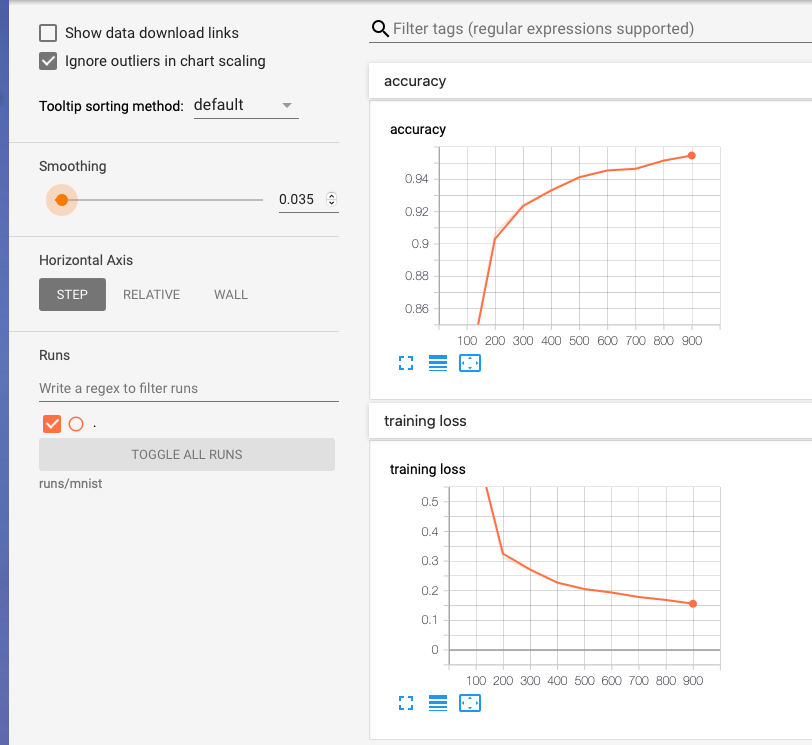

So we can analyse the results and check the accuracy and loss and if we saw some problems we can e.g. change the learning rate.
For example, if we change the lr here, we should have one curve for each lr. So a blue colored line will be added to this curve.

check pytorch.org for tensorboard.html for more info

So now in this part let's draw the precision. add_pr_curve()

In [168]:
# test
class_labels = []
class_preds = []
with torch.no_grad():
    n_correct = 0 
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device) # and send it to GPU if it's there
        labels = labels.to(device)
        outputs = model(images)
        
        #torch.max returns value and index but we need index
        values, predictions = torch.max(outputs.data, 1)
        n_samples += labels.size(0)  #number of sample and current batch = should be 100
        #print(n_samples)
        n_correct += (predictions == labels).sum().item()
        
        #added for tensorboard------------
        #we need probabilities between 0 and 1- we want to have actual probabilities
        #so we need softmax here for our outputs
        class_probs_batch = [F.softmax(output, dim=0) for output in outputs]
        
        class_preds.append(class_probs_batch)
        class_labels.append(predictions)
        #added for tensorboard------------
       
    #added for tensorboard------------
    #conversion to tensors, concatenate all the elements in our list along one dimension
    class_labels = torch.cat(class_labels)
    #for predictions we want to have two dimensional, for each class we want to stack the predictions and concat them
    class_preds = torch.cat([torch.stack(batch) for batch in class_preds])
    
    acc = 100.0 * n_correct / n_samples #accuracy
    print(f'accuracy = {acc}')
    
    #added for tensorboard------------
    classes = range(10)
    for i in classes:
        labels_i = class_labels == i
        preds_i = class_preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()
    #added for tensorboard------------

accuracy = 95.87


Reloading the tensorboard tab we will see:
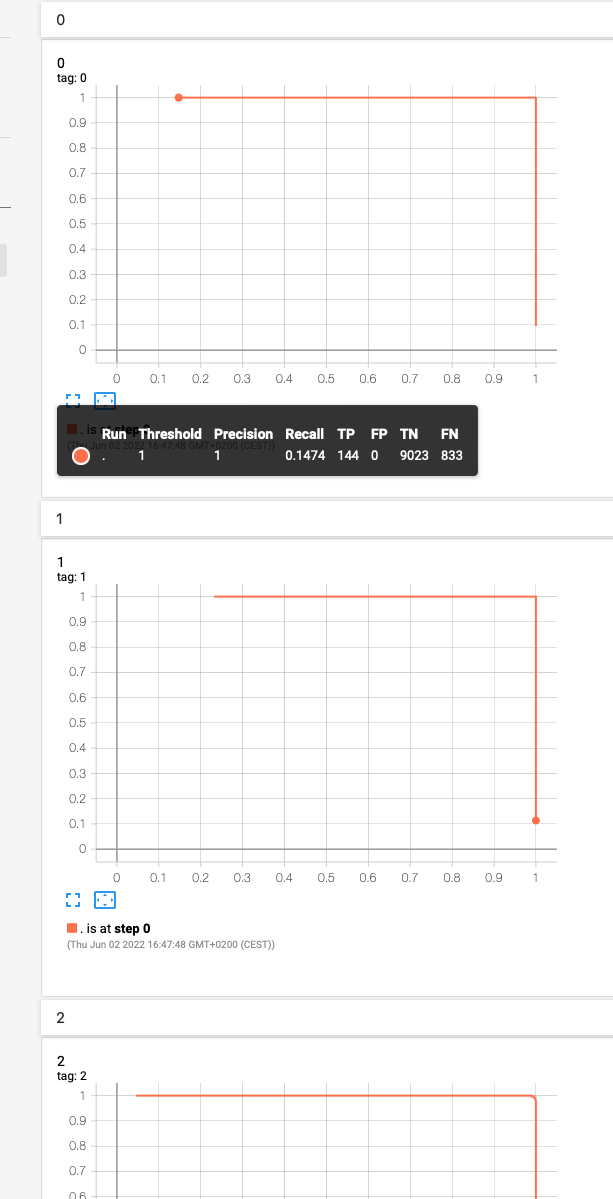

and we can investigate the different TP, FP and so on for each run.